# ST-GNN Yield Prediction Training

Trains a Spatio-Temporal Graph Neural Network for tobacco yield prediction.

**Architecture:**
- Graph Convolution: Models spatial relationships between Sensor_1 and Sensor_2
- Temporal Convolution: Captures time series patterns over 7-day windows
- Fusion & Prediction: Combines spatial-temporal features for yield regression

In [1]:
# 0) Setup
import sys
sys.path.append('/Users/dominicmushayi/Documents/Capstone /Project/backend')
import os, json, warnings
from datetime import datetime
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from ml_pipeline.models.st_gnn import create_model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Paths
REPO_ROOT = '/Users/dominicmushayi/Documents/Capstone /Project'
DATA_CSV = os.path.join(REPO_ROOT, 'notebooks/cropiot.sensor_data.csv')
HARVEST_CSV = os.path.join(REPO_ROOT, 'notebooks/actual_yield.csv')
MODELS_DIR = '/Users/dominicmushayi/Documents/GitHub/Capstone-project-fullstack-/backend/ml_pipeline/models'
os.makedirs(MODELS_DIR, exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

Using device: cpu


## 1) Load and Prepare Data

In [2]:
# Load sensor data
df = pd.read_csv(DATA_CSV)
df.columns = df.columns.str.strip()
df['timestamp'] = pd.to_datetime(
    df['timestamp'].astype(str).str.strip(),
    format='ISO8601',
    utc=True,
    errors='raise'   # change to 'coerce' if you want invalid ones -> NaT
)
df.replace(-999.0, np.nan, inplace=True)

# Clean and sort
df = df.dropna(subset=['temperature', 'humidity']).copy()
df = df.sort_values(['sensor_id', 'timestamp']).reset_index(drop=True)

# Forward fill pH and soil_moisture
for sensor in df['sensor_id'].unique():
    mask = df['sensor_id'] == sensor

    df.loc[mask, 'ph'] = (
        df.loc[mask, 'ph']
          .ffill()
          .fillna(6.0)
    )

    df.loc[mask, 'soil_moisture'] = (
        df.loc[mask, 'soil_moisture']
          .ffill()
          .fillna(50)
    )


print(f'Loaded {len(df)} rows from {len(df.sensor_id.unique())} sensors')
print(f'Date range: {df.timestamp.min()} to {df.timestamp.max()}')
df.head()

Loaded 41610 rows from 2 sensors
Date range: 2025-10-30 00:05:00+00:00 to 2026-02-11 23:55:00+00:00


,_id,timestamp,sensor_id,soil_moisture,ph,temperature,humidity,rssi,snr,created_at
0,69088cae0633c746f8a09060,2025-10-30 00:05:00+00:00,Sensor_1,100,6.07,31.8,66.1,-56,9.75,2025-11-03T13:06:22.307Z
1,69088cea0633c746f8a09061,2025-10-30 00:10:00+00:00,Sensor_1,100,6.44,32.5,39.5,-62,9.25,2025-11-03T13:07:22.423Z
2,69088e160633c746f8a09066,2025-10-30 00:15:00+00:00,Sensor_1,100,6.15,30.4,41.3,-56,9.25,2025-11-03T13:12:22.780Z
3,69088e520633c746f8a09067,2025-10-30 00:20:00+00:00,Sensor_1,100,6.06,30.3,41.6,-60,9.25,2025-11-03T13:13:22.873Z
4,69088e8e0633c746f8a09068,2025-10-30 00:25:00+00:00,Sensor_1,100,6.18,30.2,42.0,-61,10.00,2025-11-03T13:14:22.962Z


## 2) Create Sequence Dataset

ST-GNN needs sequences: (batch, seq_len, num_nodes, num_features)

In [3]:
# Feature engineering
feature_names = ['temperature', 'humidity', 'soil_moisture', 'ph']

# Add VPD
df['vpd'] = 0.611 * np.exp((17.502 * df['temperature']) / (df['temperature'] + 240.97)) * (1 - df['humidity'] / 100)
feature_names.append('vpd')

# Normalize features per sensor
feature_stats = {}
for feat in feature_names:
    feature_stats[feat] = {'mean': df[feat].mean(), 'std': df[feat].std()}
    df[feat] = (df[feat] - feature_stats[feat]['mean']) / (feature_stats[feat]['std'] + 1e-8)

print(f'Using {len(feature_names)} features: {feature_names}')
print('Feature stats:', json.dumps({k: {sk: round(sv, 2) for sk, sv in v.items()} for k, v in feature_stats.items()}, indent=2))

Using 5 features: ['temperature', 'humidity', 'soil_moisture', 'ph', 'vpd']
Feature stats: {
  "temperature": {
    "mean": 21.11,
    "std": 4.26
  },
  "humidity": {
    "mean": 83.4,
    "std": 12.92
  },
  "soil_moisture": {
    "mean": 72.36,
    "std": 15.5
  },
  "ph": {
    "mean": 6.12,
    "std": 0.06
  },
  "vpd": {
    "mean": 0.5,
    "std": 0.53
  }
}


In [4]:
# Generate simulated yields (calibrated with actual data)
if os.path.exists(HARVEST_CSV):
    ydf = pd.read_csv(HARVEST_CSV)
    ydf.columns = ydf.columns.str.strip()
    ydf['yield_kg_per_ha'] = ydf['yield_kg_per_ha'].astype(float)
    min_y, max_y = ydf['yield_kg_per_ha'].min(), ydf['yield_kg_per_ha'].max()
    print(f'Calibrating simulation with actual yield range: {min_y:.0f} - {max_y:.0f} kg/ha')
else:
    min_y, max_y = 1500, 3500

# Simple yield simulation based on normalized features
def simulate_yield(row):
    # Denormalize for scoring
    temp = row['temperature'] * feature_stats['temperature']['std'] + feature_stats['temperature']['mean']
    humid = row['humidity'] * feature_stats['humidity']['std'] + feature_stats['humidity']['mean']
    moist = row['soil_moisture'] * feature_stats['soil_moisture']['std'] + feature_stats['soil_moisture']['mean']
    ph_val = row['ph'] * feature_stats['ph']['std'] + feature_stats['ph']['mean']
    
    # Optimal conditions
    temp_score = max(0, 1 - abs(temp - 26) / 15)
    humid_score = max(0, 1 - abs(humid - 55) / 30)
    moist_score = max(0, 1 - abs(moist - 70) / 30)
    ph_score = max(0, 1 - abs(ph_val - 6.0) / 1.5)
    
    score = (temp_score + humid_score + moist_score + ph_score) / 4
    base_yield = min_y + score * (max_y - min_y)
    noise = np.random.normal(0, 0.08)
    return base_yield * (1 + noise)

df['yield_kg_per_ha'] = df.apply(simulate_yield, axis=1).clip(min_y, max_y)
print(f"Yield range: {df['yield_kg_per_ha'].min():.0f} - {df['yield_kg_per_ha'].max():.0f} kg/ha")

Calibrating simulation with actual yield range: 0 - 3218 kg/ha
Yield range: 676 - 3218 kg/ha


In [5]:
# Create sequences for ST-GNN
SEQ_LEN = 168  # 7 days of hourly data
sensor_ids = sorted(df['sensor_id'].unique())
num_nodes = len(sensor_ids)
sensor_to_idx = {s: i for i, s in enumerate(sensor_ids)}

print(f'Creating sequences of length {SEQ_LEN} hours ({SEQ_LEN/24:.1f} days)')
print(f'Sensors: {sensor_ids} -> node indices {list(sensor_to_idx.values())}')

# Group by sensor and create sliding windows
sequences = []
targets = []

for sensor in sensor_ids:
    sensor_df = df[df['sensor_id'] == sensor].reset_index(drop=True)
    
    for i in range(len(sensor_df) - SEQ_LEN):
        seq = sensor_df.iloc[i:i+SEQ_LEN]
        target_row = sensor_df.iloc[i+SEQ_LEN]
        
        # Extract features for this sequence
        seq_features = seq[feature_names].values  # (SEQ_LEN, num_features)
        
        # Create node features: replicate this sensor's sequence to all nodes
        # (Other nodes will have zeros, filled by adjacency during GCN)
        node_features = np.zeros((SEQ_LEN, num_nodes, len(feature_names)))
        node_idx = sensor_to_idx[sensor]
        node_features[:, node_idx, :] = seq_features
        
        sequences.append(node_features)
        targets.append(target_row['yield_kg_per_ha'])

sequences = np.array(sequences)  # (N, SEQ_LEN, num_nodes, num_features)
targets = np.array(targets)      # (N,)

print(f'Created {len(sequences)} sequences')
print(f'Sequence shape: {sequences.shape}')
print(f'Target shape: {targets.shape}')

Creating sequences of length 168 hours (7.0 days)
Sensors: [' Sensor_1 ', ' Sensor_2 '] -> node indices [0, 1]
Created 41274 sequences
Sequence shape: (41274, 168, 2, 5)
Target shape: (41274,)


## 3) Create Adjacency Matrix

In [6]:
# Simple adjacency: all sensors connected (fully connected graph)
# You can customize this based on physical sensor locations
adj_matrix = torch.ones(num_nodes, num_nodes)
print(f'Adjacency matrix shape: {adj_matrix.shape}')
print('Adjacency matrix (1=connected):')
print(adj_matrix.numpy().astype(int))

Adjacency matrix shape: torch.Size([2, 2])
Adjacency matrix (1=connected):
[[1 1]
 [1 1]]


## 4) Create PyTorch Dataset and DataLoader

In [7]:
class YieldDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.FloatTensor(sequences)
        self.targets = torch.FloatTensor(targets).unsqueeze(1)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Split: 80% train, 20% test (time-aware)
split_idx = int(len(sequences) * 0.8)
train_sequences, test_sequences = sequences[:split_idx], sequences[split_idx:]
train_targets, test_targets = targets[:split_idx], targets[split_idx:]

train_dataset = YieldDataset(train_sequences, train_targets)
test_dataset = YieldDataset(test_sequences, test_targets)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Train: {len(train_dataset)} samples')
print(f'Test: {len(test_dataset)} samples')

Train: 33019 samples
Test: 8255 samples


## 5) Initialize ST-GNN Model

In [8]:
config = {
    'model_type': 'stgnn',
    'num_features': len(feature_names),
    'num_nodes': num_nodes,
    'hidden_dim': 32,
    'num_gcn_layers': 2,
    'tcn_channels': [32, 32],
    'kernel_size': 3,
    'dropout': 0.3
}

model = create_model(config).to(device)
adj_matrix = adj_matrix.to(device)

print(f'\nModel parameters: {sum(p.numel() for p in model.parameters()):,}')


Model parameters: 8,449


## 6) Training Loop

In [ ]:
# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

NUM_EPOCHS = 100
EARLY_STOP_PATIENCE = 20

best_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

print('Starting training...\n')

for epoch in range(NUM_EPOCHS):
    # Training
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        pred = model(batch_x, adj_matrix)
        loss = criterion(pred, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            pred = model(batch_x, adj_matrix)
            loss = criterion(pred, batch_y)
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), os.path.join(MODELS_DIR, 'stgnn_best.pth'))
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {optimizer.param_groups[0]["lr"]:.6f}')
    
    if patience_counter >= EARLY_STOP_PATIENCE:
        print(f'\nEarly stopping at epoch {epoch+1}')
        break

print(f'\nBest validation loss: {best_loss:.4f}')

Starting training...

Epoch 10/100 | Train Loss: 253584.1018 | Val Loss: 121539.8724 | LR: 0.001000


## 7) Evaluation


=== Test Set Results ===
R² Score: 0.7435
RMSE: 234.49 kg/ha
MAE: 184.09 kg/ha


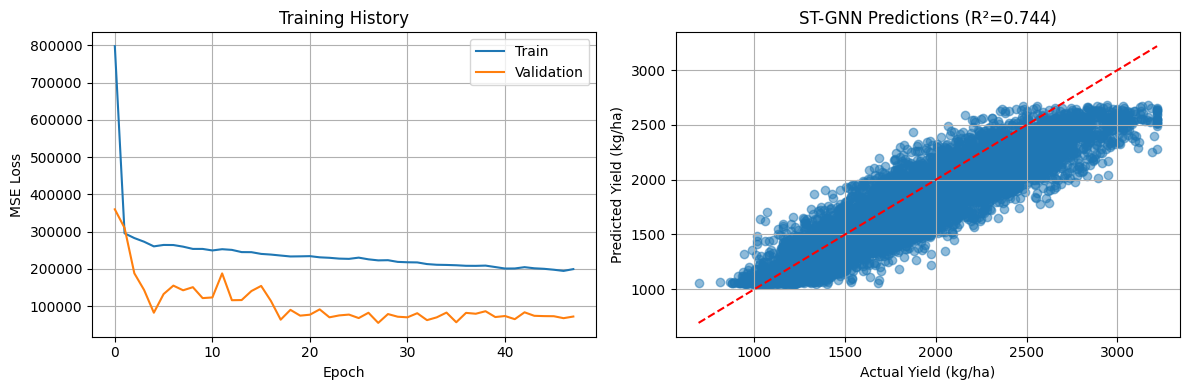

In [13]:
# Load best model
model.load_state_dict(torch.load(os.path.join(MODELS_DIR, 'stgnn_best.pth')))
model.eval()

# Predictions
all_preds = []
all_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        pred = model(batch_x, adj_matrix)
        all_preds.append(pred.cpu().numpy())
        all_targets.append(batch_y.numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math

r2 = r2_score(all_targets, all_preds)
rmse = math.sqrt(mean_squared_error(all_targets, all_preds))
mae = mean_absolute_error(all_targets, all_preds)

print(f'\n=== Test Set Results ===')
print(f'R² Score: {r2:.4f}')
print(f'RMSE: {rmse:.2f} kg/ha')
print(f'MAE: {mae:.2f} kg/ha')

# Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(all_targets, all_preds, alpha=0.5)
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--')
plt.xlabel('Actual Yield (kg/ha)')
plt.ylabel('Predicted Yield (kg/ha)')
plt.title(f'ST-GNN Predictions (R²={r2:.3f})')
plt.grid(True)

plt.tight_layout()
plt.show()

## 8) Save Model and Metadata

In [14]:
# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'config': config,
    'feature_names': feature_names,
    'feature_stats': feature_stats,
    'sensor_to_idx': sensor_to_idx,
    'adj_matrix': adj_matrix.cpu().numpy().tolist(),
    'seq_len': SEQ_LEN
}, os.path.join(MODELS_DIR, 'stgnn_yield_model.pth'))

# Save metadata
metadata = {
    'model_type': 'ST-GNN',
    'training_date': datetime.utcnow().isoformat(),
    'test_r2_score': float(r2),
    'test_rmse': float(rmse),
    'test_mae': float(mae),
    'num_features': len(feature_names),
    'features': feature_names,
    'num_nodes': num_nodes,
    'seq_len': SEQ_LEN,
    'training_samples': len(train_dataset),
    'test_samples': len(test_dataset),
    'model_params': sum(p.numel() for p in model.parameters())
}

with open(os.path.join(MODELS_DIR, 'stgnn_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=2)

print('\n✓ Model and metadata saved!')
print(f'  - Model: {MODELS_DIR}/stgnn_yield_model.pth')
print(f'  - Metadata: {MODELS_DIR}/stgnn_metadata.json')


✓ Model and metadata saved!
  - Model: /Users/dominicmushayi/Documents/GitHub/Capstone-project-fullstack-/backend/ml_pipeline/models/stgnn_yield_model.pth
  - Metadata: /Users/dominicmushayi/Documents/GitHub/Capstone-project-fullstack-/backend/ml_pipeline/models/stgnn_metadata.json
